In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2
from keras.regularizers import l1
from keras.models import load_model

#Run vs Pass classification NFL
def build():
    network = keras.models.Sequential()
    network.add(Dense(182, activation = 'elu', input_shape=(x_train.shape[1],), kernel_regularizer=l1(1.e-4)))
    network.add(Dense(24, activation = 'relu', kernel_regularizer=l2(1.e-3)))
    network.add(Dense(1, activation = 'sigmoid'))
    network.compile(loss='binary_crossentropy', optimizer="adamax" ,metrics=['accuracy'])
    return network



#Data preparation for classification NFL
def data_prep(data):
    y = data['play_type']
    x = data.drop(columns = ['play_type'])
    x = pd.get_dummies(x)
    y = y.apply(playtypetobinary)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    cols = ['yardline_100', 'quarter_seconds_remaining', 'ydstogo', 'score_differential']
    for x in cols:
        mean = x_train[x].mean(axis=0)
        x_train[x] -= mean
        std = x_train[x].std(axis=0)
        x_train[x] /= std
        x_test[x] -= mean
        x_test[x] /= std
    return x_train, x_test, y_train, y_test

#Classification k-cross-validation
def cross_valid_reg(k, num_epochs, x_train, y_train, x_test, y_test):
    samples = len(x_train) // k
    val_history = []
    train_history = []
    for i in range(k):
        data = x_train[i * samples: (i + 1) * samples]
        targets = y_train[i * samples: (i + 1) * samples]
        partial_train_data = np.concatenate([x_train[:i * samples], x_train[(i + 1) * samples:]],axis=0)
        partial_train_targets = np.concatenate([y_train[:i * samples],y_train[(i + 1) * samples:]],axis=0)
        model = build()
        if i == 0:
            print('Input size: ', x_train.shape)
            print(model.summary())
        hist = model.fit(partial_train_data, partial_train_targets, validation_data=(data, targets),
                         epochs=num_epochs, batch_size=100, verbose=0)
        loss_history1 = hist.history['val_loss']
        loss_history2 = hist.history['loss']
        val_history.append(loss_history1)
        train_history.append(loss_history2)
        
    val_history = [np.mean([x[i] for x in val_history]) for i in range(num_epochs)]
    train_history = [np.mean([x[i] for x in train_history]) for i in range(num_epochs)]
    plt.plot(range(1, len(val_history) + 1), val_history)
    plt.plot(range(1, len(train_history) + 1), train_history)
    plt.xlabel('Epochs')
    plt.ylabel('loss_function')
    plt.legend(['Validation', 'Training'])
    plt.show()
    _,mae = model.evaluate(x_test, y_test)
    print('Accuracy of the network is ', mae)
    with open('historyClassNFL.txt', 'w') as outfile:
        for x in range(len(val_history)):
            print(x, ' ', val_history[x], ' ', train_history[x], file=outfile)
    
    return model
    
def playtypetobinary(x):
    if x=='run':
        x = 0
    else:
        x = 1
    return x

def team_eval(model, data, name):
    y = data['play_type']
    x = data.drop(columns = ['play_type'])
    x = pd.get_dummies(x)
    y = y.apply(playtypetobinary)
    cols = ['yardline_100', 'quarter_seconds_remaining', 'ydstogo', 'score_differential']
    for i in cols:
        mean = x[i].mean()
        x[i] -= mean
        std = x[i].std()
        x[i] /= std
    
    _,acc = model.evaluate(x, y)
    print(name, ' was predictable in ', acc, ' cases.')
    return name,acc

In [28]:
data = pd.read_csv("data/readyToGoNFL.csv")
data.drop(columns = ['defteam'], inplace = True)
print(data.shape)
len(data[260000:].posteam.unique().tolist())

(322921, 13)


32

In [29]:
df = data[260000:]
teams = []
names = df.posteam.unique().tolist()
for t in names:
    teams.append(df.where(df['posteam'] == t).dropna().drop(columns = ['posteam', 'yards_gained']))
    
data.drop(columns = ['posteam'], inplace = True)
data.drop(columns=['yards_gained'], inplace=True)
x_train, x_test, y_train, y_test = data_prep(data)

In [30]:
model = build()
model.fit(x_train, y_train, epochs=50, batch_size=128, verbose = 0)

In [41]:
result = []
i = 0
for t in teams:
    try:
        result.append(team_eval(model, t.sample(1800), names[i]))
    except:
        print(names[i], ' does not work!!!')
    i = i + 1


57/57 [==============================] - 0s 975us/step - loss: 0.4985 - accuracy: 0.7694
ARI  was predictable in  0.769444465637207  cases.
LA  does not work!!!
DEN  does not work!!!
57/57 [==============================] - 0s 951us/step - loss: 0.5159 - accuracy: 0.7511
OAK  was predictable in  0.7511110901832581  cases.
57/57 [==============================] - 0s 956us/step - loss: 0.5204 - accuracy: 0.7483
WAS  was predictable in  0.7483333349227905  cases.
57/57 [==============================] - 0s 1ms/step - loss: 0.4956 - accuracy: 0.7572
NYG  was predictable in  0.7572222352027893  cases.
57/57 [==============================] - 0s 1ms/step - loss: 0.5454 - accuracy: 0.7144
SF  was predictable in  0.7144444584846497  cases.
57/57 [==============================] - 0s 838us/step - loss: 0.6147 - accuracy: 0.6678
SEA  was predictable in  0.6677777767181396  cases.
57/57 [==============================] - 0s 939us/step - loss: 0.4840 - accuracy: 0.7778
NO  was predictable in  0.77

In [40]:
for t in teams:
    print(t)

        yardline_100  quarter_seconds_remaining     qtr    down  ydstogo  \
260000          59.0                       35.0   third  second      7.0   
260001          69.0                      864.0  fourth   third     17.0   
260004          19.0                      803.0  fourth   first     10.0   
260005          19.0                      798.0  fourth  second     10.0   
260006          16.0                      755.0  fourth   third      7.0   
...              ...                        ...     ...     ...      ...   
321790           7.0                      199.0  fourth  fourth      7.0   
321794          68.0                       67.0  fourth   first     10.0   
321795          51.0                       41.0  fourth   first     10.0   
321796          35.0                       19.0  fourth   first     10.0   
321797          35.0                       15.0  fourth  second     10.0   

       play_type  shotgun  no_huddle posteam_timeouts_remaining  \
260000       run    

In [37]:
results.sort(key = lambda x: x[1])
print(results)

[('SEA', 0.6654982566833496), ('BAL', 0.6945932507514954), ('GB', 0.7044433355331421), ('PHI', 0.7045454382896423), ('MIA', 0.7056892514228821), ('BUF', 0.708185076713562), ('KC', 0.7085505723953247), ('HOU', 0.7121369242668152), ('CIN', 0.7134955525398254), ('SF', 0.7164251208305359), ('JAX', 0.7218413352966309), ('TB', 0.7261020541191101), ('TEN', 0.7290219068527222), ('IND', 0.7367088794708252), ('NYJ', 0.7371761202812195), ('CLE', 0.7393752932548523), ('CHI', 0.7418493032455444), ('OAK', 0.7479296326637268), ('WAS', 0.7496151924133301), ('DAL', 0.7573603987693787), ('LAC', 0.760800838470459), ('MIN', 0.760903000831604), ('ARI', 0.7631441950798035), ('PIT', 0.7681302428245544), ('NYG', 0.7685415744781494), ('NO', 0.7810361385345459)]


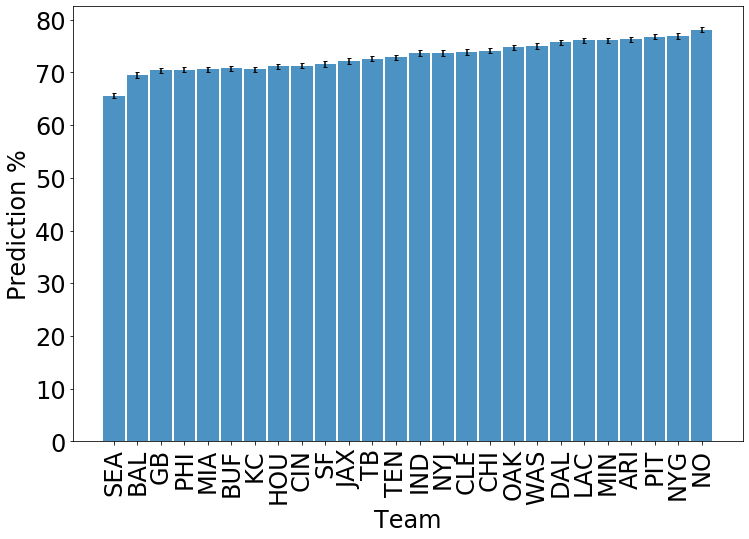

In [22]:
score = [65.6, 69.5, 70.4, 70.5, 70.6, 70.8, 70.6, 71.2, 71.3, 71.6, 72.2, 72.6, 72.9, 73.7, 73.7, 73.9, 74.1, 74.8, 75.0, 75.7, 76.1, 76.1, 76.3, 76.8, 76.9, 78.1]
teams = ['SEA', 'BAL', 'GB', 'PHI', 'MIA', 'BUF', 'KC', 'HOU', 'CIN', 'SF', 'JAX', 'TB', 'TEN', 'IND', 'NYJ', 'CLE', 'CHI', 'OAK', 'WAS', 'DAL', 'LAC', 'MIN', 'ARI', 'PIT', 'NYG', 'NO']
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 24})
plt.bar(teams, score, width=0.9, yerr=0.5, alpha=0.8, ecolor='black', capsize=2)
plt.xticks(rotation=90)
plt.xlabel('Team')
plt.ylabel('Prediction %')
plt.savefig('Teams.png')

In [44]:
for y in range(32):
    for x in range(10):
        print(results[x][y])
    print('*')

('ARI', 0.7600208520889282)
('ARI', 0.7636647820472717)
('ARI', 0.7615824937820435)
('ARI', 0.766788125038147)
('ARI', 0.7709526419639587)
('ARI', 0.7621030807495117)
('ARI', 0.7641853094100952)
('ARI', 0.7719937562942505)
('ARI', 0.7631441950798035)
('ARI', 0.7657470107078552)
*
('OAK', 0.7494823932647705)
('OAK', 0.7479296326637268)
('OAK', 0.7458592057228088)
('OAK', 0.7494823932647705)
('OAK', 0.7494823932647705)
('OAK', 0.7494823932647705)
('OAK', 0.75)
('OAK', 0.7515528202056885)
('OAK', 0.75)
('OAK', 0.7479296326637268)
*
('WAS', 0.7501282691955566)
('WAS', 0.7501282691955566)
('WAS', 0.7506413459777832)
('WAS', 0.7501282691955566)
('WAS', 0.747562825679779)
('WAS', 0.747562825679779)
('WAS', 0.7480759620666504)
('WAS', 0.7511544227600098)
('WAS', 0.7496151924133301)
('WAS', 0.7465366721153259)
*
('NYG', 0.7670482993125916)
('NYG', 0.7655550241470337)
('NYG', 0.766052782535553)
('NYG', 0.7700348496437073)
('NYG', 0.7620706558227539)
('NYG', 0.7690393328666687)
('NYG', 0.76505726

IndexError: list index out of range